# 04. Criando CSVs

A geração de CSV é realizada utilizando script em python que estão no diretório 

aqui o código é em python
Segundo o README.md
>### Create CSV files by listing the generated samples for datagenerator 
>
><br/>
>
>All the Python scripts including the scripts to generate CSV are with the directory ```SiMWiSense/Python_code/```
>
><br/>
>
>==> execute the script ``` csv_main.py ``` which takes the Test name (proximity / coarse / fine_grained) as an argument. For example:
><br/>
>```
>python csv_main.py proximity
>```
><br/>

Esse código roda quase instaneamente.

- Ele gera arquivos de CSV com duas colunas: filename, label.
- O arquivos são gerados segundo divisão dos batches e slots do passo anterior
- Não parece existir nenhuma normalização no valor.
- 

In [49]:
import os
import pandas as pd
import numpy as np
import scipy.io
from pathlib import Path
from tqdm import tqdm


def add_shape(row_csv_df, base_folder):
  mat_file_path = row_csv_df['filename']
  data = scipy.io.loadmat(f'{base_folder}/{mat_file_path}')
  row_csv_df['nr_packets'], row_csv_df['nr_subcarriers'] = data['csi_mon'].shape                     
  return row_csv_df


df_all = pd.DataFrame({
  'test': [],
  'environment': [],
  'monitor': [],
  'slot': [],
  'csv_file_path': [], 
  'filename': [],
  'label':  [],
  'nr_packets': [],
  'nr_subcarriers': []
})

file_paths = Path('../Data').rglob('*.csv')

for file_path in tqdm(sorted(file_paths)):
  # print(f'Processing {file_path}')
  file_path = str(file_path)
  df = pd.read_csv(file_path)
  base_folder = os.path.dirname(file_path)
  df = df.apply(add_shape, axis=1, base_folder=base_folder)
  file_path_splited = file_path.split('/')
  test = file_path_splited[2]
  environment = file_path_splited[3]
  monitor = file_path_splited[6]
  slot = file_path_splited[8]
  df['test'] = test
  df['environment'] = environment
  df['monitor'] = monitor
  df['slot'] = slot 
  df['csv_file_path'] = file_path
  df = df[['test', 'environment', 'monitor', 'slot', 'csv_file_path', 'filename', 'label', 'nr_packets', 'nr_subcarriers']]
  df_all = pd.concat([df_all, df], ignore_index=True)
  
  

100%|██████████| 90/90 [45:32<00:00, 30.36s/it]


In [51]:
df_all.to_csv('SAIDAS/04-csv_summary.csv', index=False)

In [74]:
# Percebi que não anotei direto se o arquivos faz parte do conjunto de validação, vou pegar isso do nome do arquivo
# crie uma coluna set que pode assumir os valores train, val ou test dependendo do nome do arquivo em csv_file_path
df_all['set'] = df_all['csv_file_path'].apply(lambda x: 'val' if 'val' in x else ('test' if 'test' in x else 'train'))
df_all.to_csv('SAIDAS/04-csv_summary.csv', index=False)

# Será que a quantidade de dados se manteve como o passo anterior?

Não, não tirou nada. É o mesmo dado do passo anteior.

E também que ele parece utilizar todos os .mat do diretório.


In [75]:
mat_original = pd.read_csv('SAIDAS/02-mat_summary.csv')
batches = pd.read_csv('SAIDAS/03-batch_summary.csv')
csvs = pd.read_csv('SAIDAS/04-csv_summary.csv')

n_pacotes_original = mat_original['shape1'].sum()
n_pacotes_apos_batches = batches['shape0'].sum()
n_pacotes_csvs = csvs['nr_packets'].sum()

print(f"Pacotes originais: {n_pacotes_original}")
print(f"Pacotes após batches: {n_pacotes_apos_batches}")
print(f"Pacotes após csvs: {n_pacotes_csvs}")

print(f'Diferença: {n_pacotes_apos_batches - n_pacotes_csvs} pacotes com o passo anterio')


Pacotes originais: 218927963
Pacotes após batches: 124820150
Pacotes após csvs: 124820150.0
Diferença: 0.0 pacotes com o passo anterio


# Qual a distribuição train, val, test ?


In [91]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_dist(df, column_to_count, title, sort_ascending=False):
  total = len(df)

  # order = df_all['label'].value_counts().index
  if sort_ascending:
    order = df[column_to_count].sort_values().unique()
  else:
    order = df_all[column_to_count].value_counts().index


  ax = sns.countplot(x=column_to_count, data=df, order=order)

  # Adiciona os percentuais acima de cada barra
  for p in ax.patches:
      count = p.get_height()
      percentage = f'{100 * count / total:.1f}%'
      ax.text(p.get_x() + p.get_width() / 2., count + 0.5, percentage,
              ha='center', va='bottom', fontsize=10)

  plt.title(title)
  plt.xlabel(column_to_count)
  plt.ylabel('Count')
  plt.xticks(rotation=45)
  plt.tight_layout()
  plt.show()

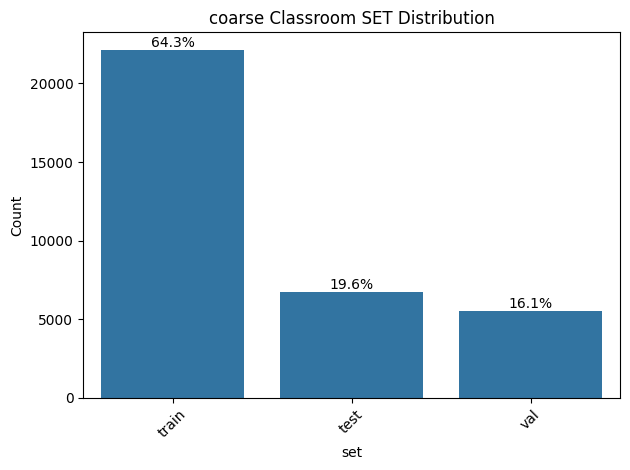

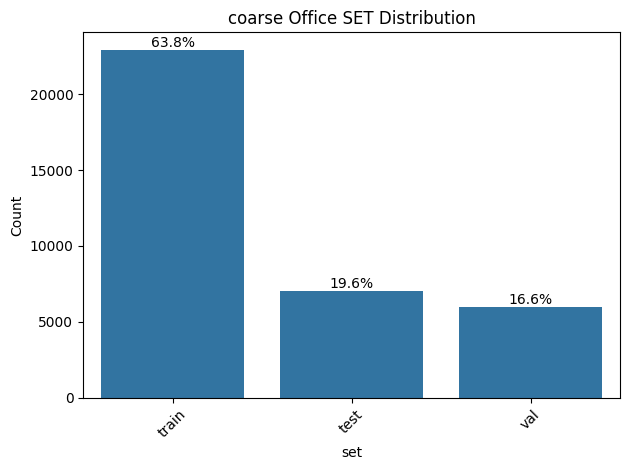

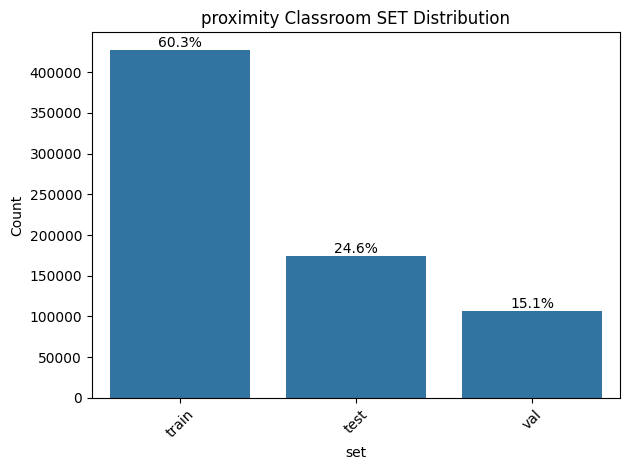

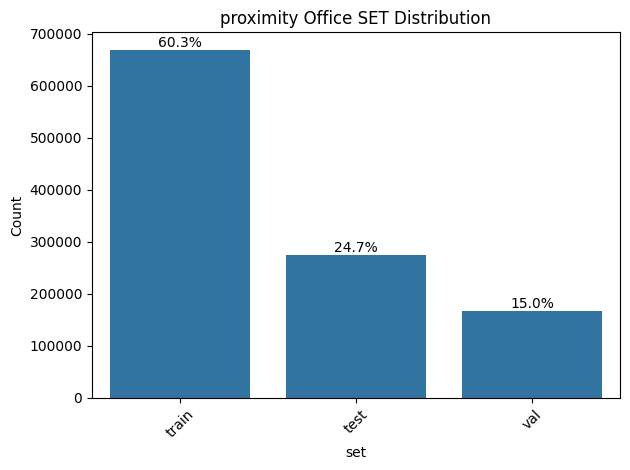

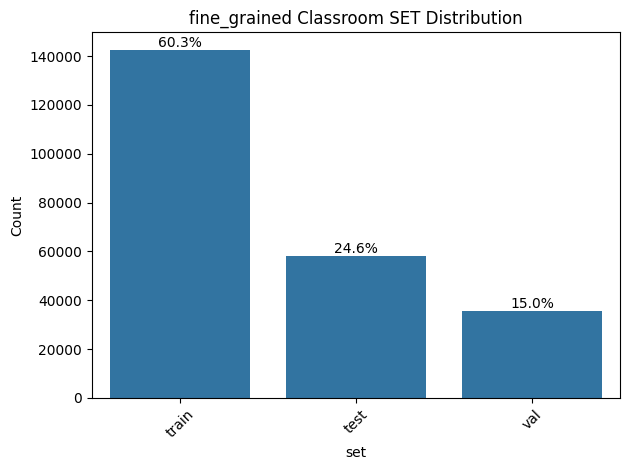

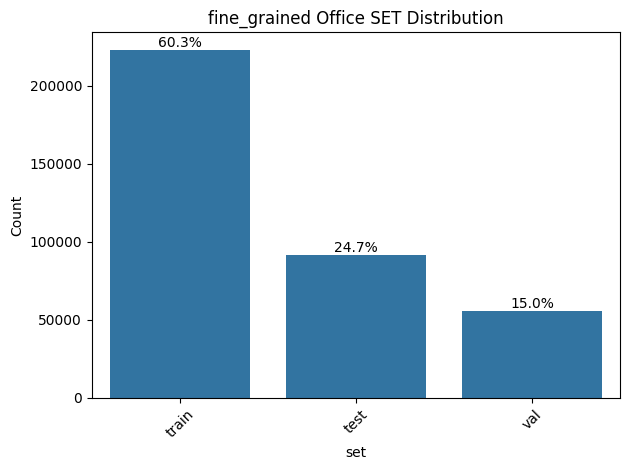

In [ ]:
# Teste: Coarse
tests = ['coarse', 'proximity', 'fine_grained']
environments = ['Classroom', 'Office']

for test in tests:
  for environment in environments:
    subset = csvs.loc[(csvs['test'] == test) & (csvs['environment'] == environment)]
    title = f'{test} {environment} SET Distribution'
    plot_dist(subset, 'set', title)



# Qual a distribuição entre as atividades dentro desses conjuntos?

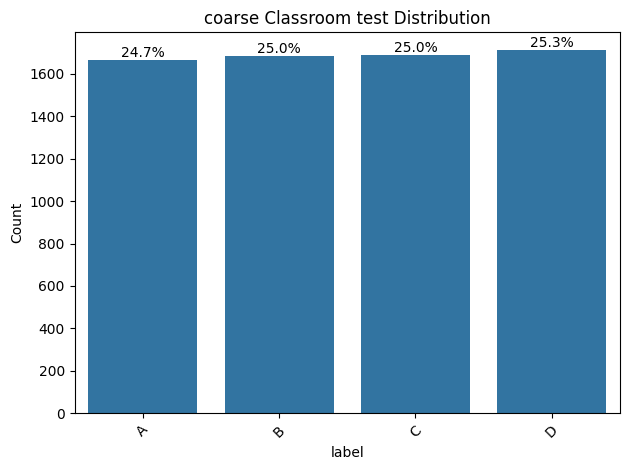

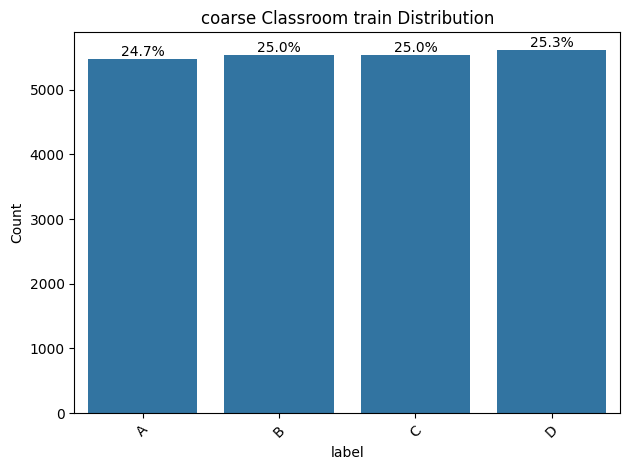

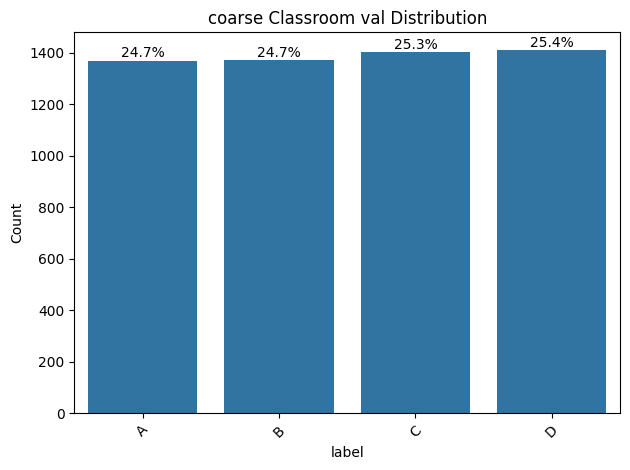

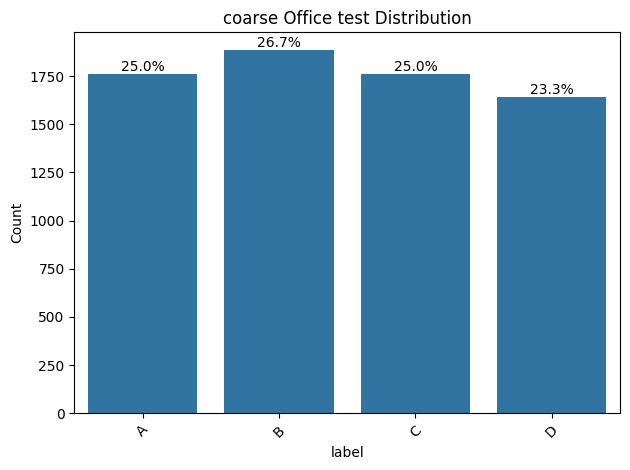

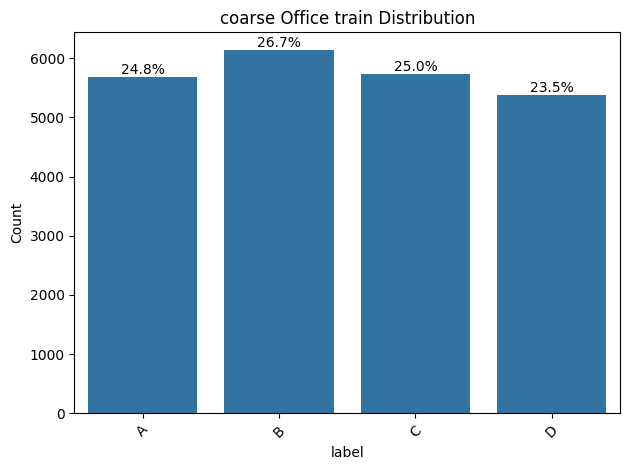

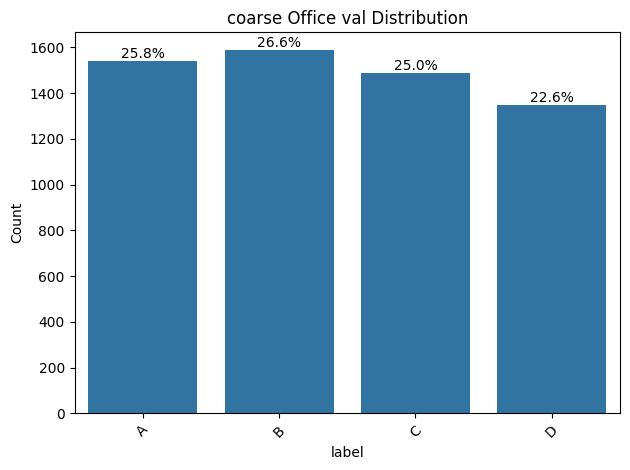

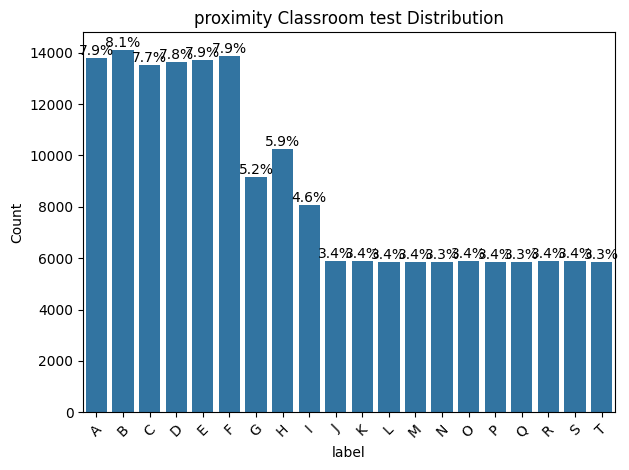

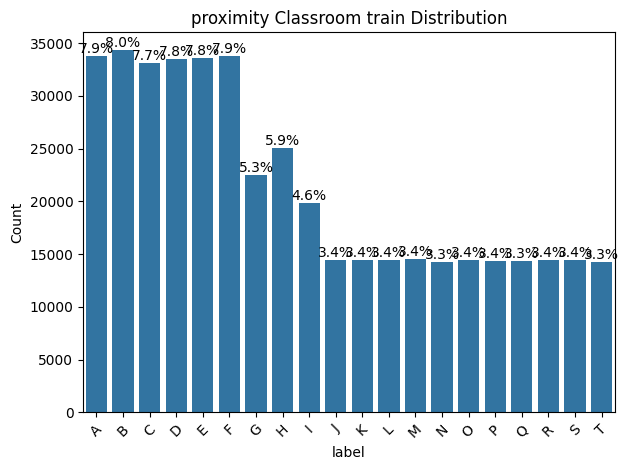

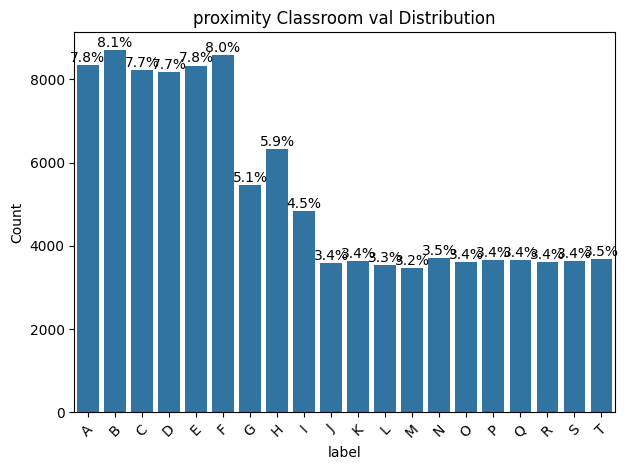

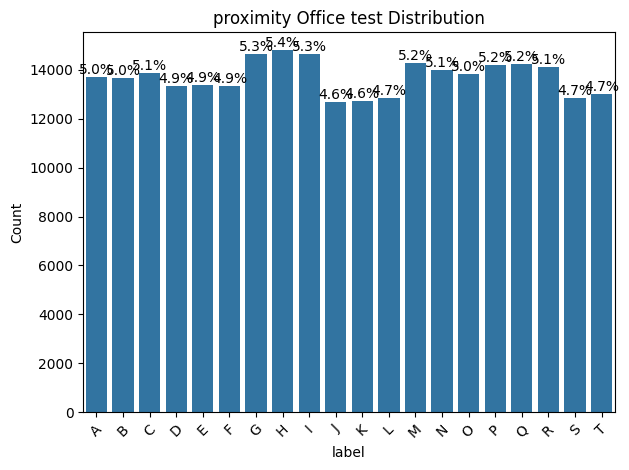

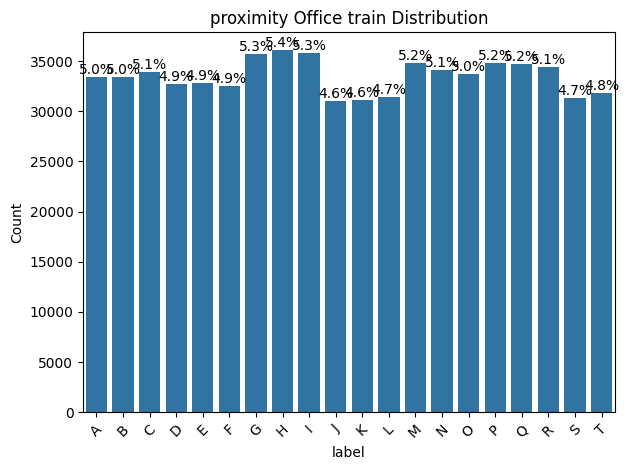

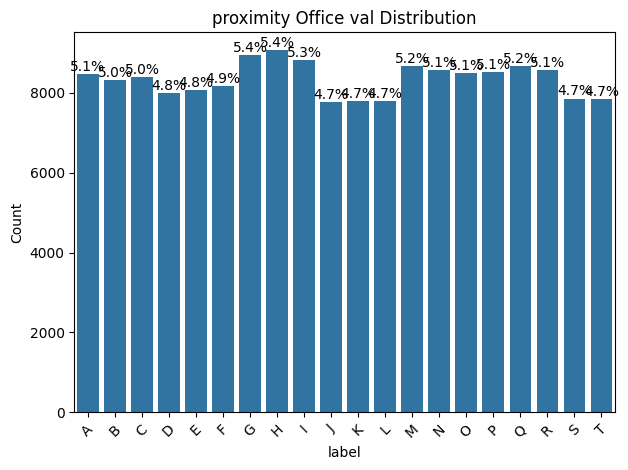

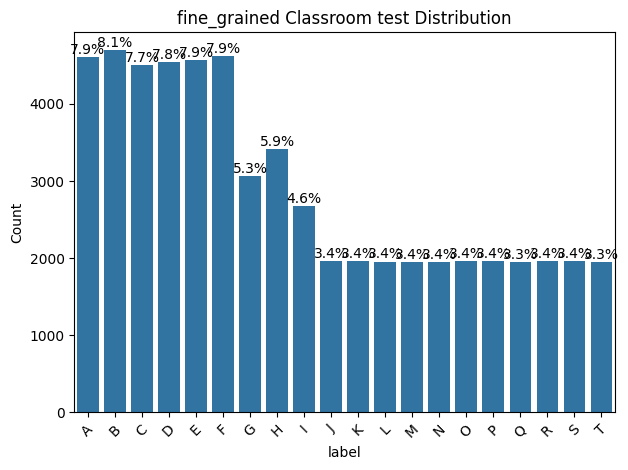

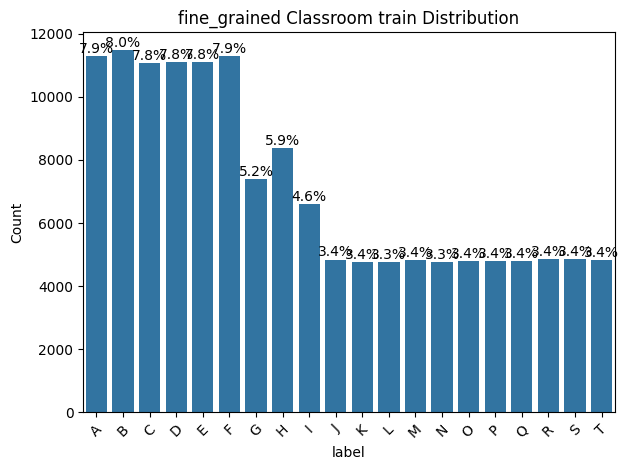

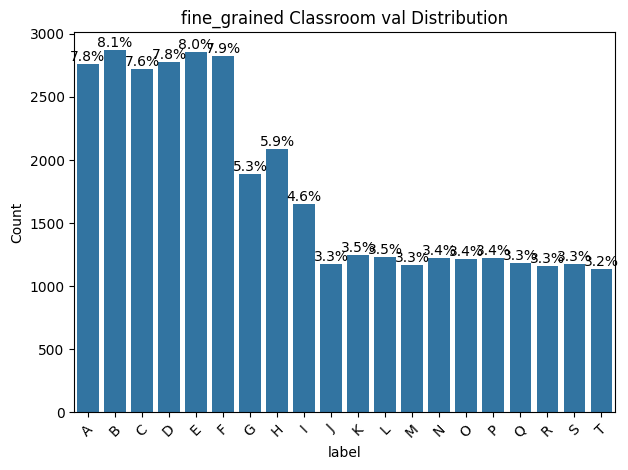

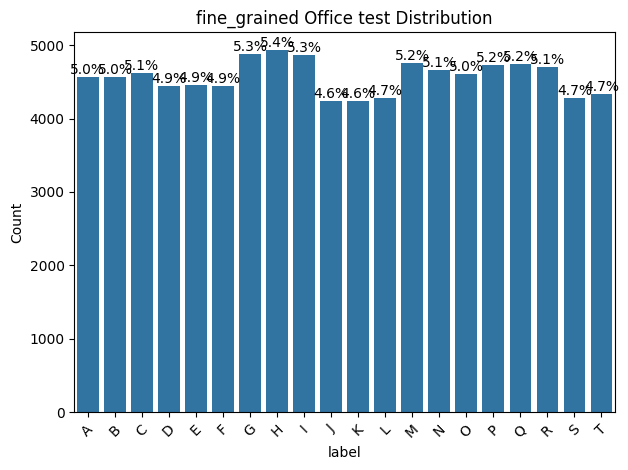

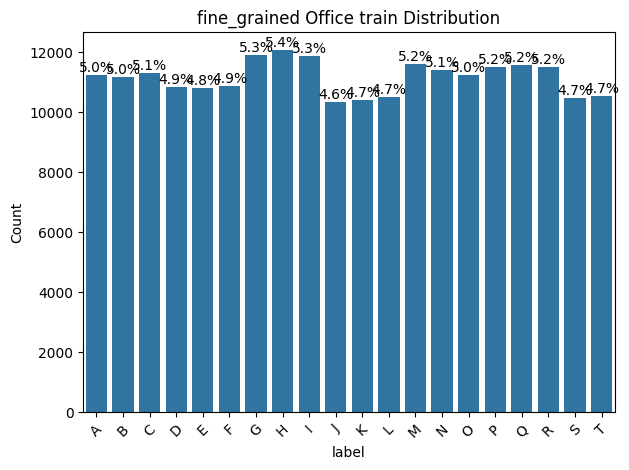

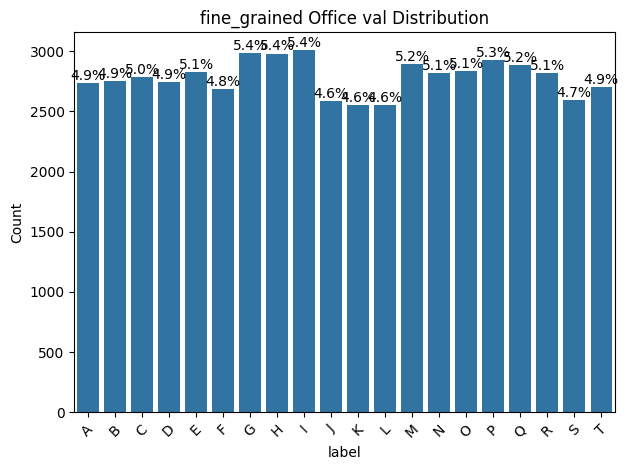

In [94]:

tests = ['coarse', 'proximity', 'fine_grained']
environments = ['Classroom', 'Office']

for test in tests:
  for environment in environments:
    subset = csvs.loc[(csvs['test'] == test) & (csvs['environment'] == environment)]
    sets = subset['set'].unique()
    for sset in sets:
      subset_set = subset[subset['set'] == sset]
      title = f'{test} {environment} {sset} Distribution'
      plot_dist(subset_set, 'label', title, sort_ascending=True)



Alguns pontos:
- As atividades não estão balanceadas no ambiente Classroom.

Será que existe dado originais que poderiam sanar essa questão?

- Realmente as atividades existem atividades com muito menos dados.

In [96]:
# select test proximity and environment Classroom in mat_orignal
subset = mat_original.loc[(mat_original['test'] == 'proximity') & (mat_original['environment'] == 'Classroom')]
subset

,test,environment,monitor,activity,min_real,max_real,min_imag,max_imag,shape0,shape1,file_path
144,proximity,Classroom,m1,A,-2047.0,2047.0,-2047.0,2047.0,242,1123914,../Data/proximity/Classroom/80MHz/3mo/m1/A/A.mat
145,proximity,Classroom,m1,B,-2047.0,2047.0,-2047.0,2047.0,242,1060829,../Data/proximity/Classroom/80MHz/3mo/m1/B/B.mat
146,proximity,Classroom,m1,C,-2047.0,2047.0,-2047.0,2047.0,242,993392,../Data/proximity/Classroom/80MHz/3mo/m1/C/C.mat
147,proximity,Classroom,m1,D,-2047.0,2047.0,-2047.0,2047.0,242,1078575,../Data/proximity/Classroom/80MHz/3mo/m1/D/D.mat
148,proximity,Classroom,m1,E,-2047.0,2047.0,-2047.0,2047.0,242,1035388,../Data/proximity/Classroom/80MHz/3mo/m1/E/E.mat
149,proximity,Classroom,m1,F,-2047.0,2047.0,-2047.0,2047.0,242,1059292,../Data/proximity/Classroom/80MHz/3mo/m1/F/F.mat
150,proximity,Classroom,m1,G,-2047.0,2047.0,-2047.0,2047.0,242,956149,../Data/proximity/Classroom/80MHz/3mo/m1/G/G.mat
151,proximity,Classroom,m1,H,-2047.0,2047.0,-2047.0,2047.0,242,711732,../Data/proximity/Classroom/80MHz/3mo/m1/H/H.mat
152,proximity,Classroom,m1,I,-2046.0,2047.0,-2043.0,2047.0,242,459734,../Data/proximity/Classroom/80MHz/3mo/m1/I/I.mat
153,proximity,Classroom,m1,J,-2047.0,2047.0,-2047.0,2047.0,242,459907,../Data/proximity/Classroom/80MHz/3mo/m1/J/J.mat


In [23]:
len(df_all['filename'].unique())

2244

# Será que ele utiliza todos os batches criados anteriormente?


In [15]:
batches = pd.read_csv('SAIDAS/03-batch_summary_grouped.csv')
batches

,test,environment,monitor,slot,nr_batches,nr_packets,nr_subcarriers
0,coarse,Classroom,m1,Test,2244,112200,242
1,coarse,Classroom,m1,Train,9207,460350,242
2,coarse,Classroom,m2,Test,2247,112350,242
3,coarse,Classroom,m2,Train,9222,461100,242
4,coarse,Classroom,m3,Test,2258,112900,242
5,coarse,Classroom,m3,Train,9264,463200,242
6,coarse,Office,m1,Test,2309,115450,242
7,coarse,Office,m1,Train,9470,473500,242
8,coarse,Office,m2,Test,2447,122350,242
9,coarse,Office,m2,Train,10033,501650,242


# Por que são 90 CSVs e não 51 (train e test ) + 26 val?